# Analog circuit for preparing a Bell state

In [18]:
from rich import print as pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 

from quantumion.interface.analog.operator import *
from quantumion.interface.analog.operations import *
from quantumion.backend.metric import *
from quantumion.backend.task import Task, TaskArgsAnalog
from quantumion.backend import QutipBackend

In [19]:
X = PauliX()
Y = PauliY()
Z = PauliZ()
I = PauliI()

n = 2  # number of qubits

# 1-qubit & 2-qubit Rabi frequencies
w1 = 2 * np.pi * 1
w2 = 2 * np.pi * 0.1

In [20]:
Hii = AnalogGate(hamiltonian= I @ I)
Hxi = AnalogGate(hamiltonian= X @ I)
Hyi = AnalogGate(hamiltonian= Y @ I)
Hxx = AnalogGate(hamiltonian= X @ X)
Hmix = AnalogGate(hamiltonian=-1 * (I @ X))
Hmxi = AnalogGate(hamiltonian=-1 * (X @ I))
Hmyi = AnalogGate(hamiltonian=-1 * (Y @ I))

In [21]:
circuit = AnalogCircuit()

# Hadamard
# circuit.evolve(duration=(3 * np.pi) / 2, gate=Hii)
circuit.evolve(duration=np.pi / 2, gate=Hxi)
circuit.evolve(duration=np.pi / 4, gate=Hmyi)

# CNOT
circuit.evolve(duration=np.pi / 4, gate=Hyi)
circuit.evolve(duration=np.pi / 4, gate=Hxx)
circuit.evolve(duration=np.pi / 4, gate=Hmix)
circuit.evolve(duration=np.pi / 4, gate=Hmxi)
circuit.evolve(duration=np.pi / 4, gate=Hmyi)
# circuit.evolve(duration=np.pi / 4, gate=Hii)

In [22]:
# define task args
args = TaskArgsAnalog(
    n_shots=100,
    fock_cutoff=4,
    metrics={
        "Z_0": Expectation(operator=(Z @ I)),
        "Z_1": Expectation(operator=(I @ Z)),
    },
    dt=1e-2,
)
task = Task(program=circuit, args=args)

In [23]:
backend = QutipBackend()
qutip_program = backend.compile(task=task)
results = backend.run(experiment=qutip_program)

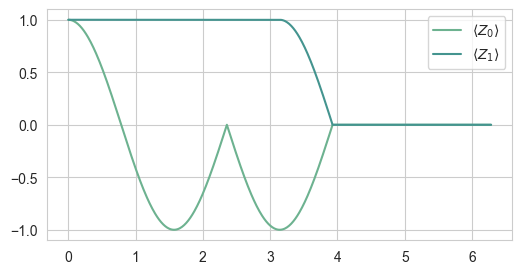

In [24]:
fig, ax = plt.subplots(1, 1, figsize=[6, 3])
colors = sns.color_palette(palette="crest", n_colors=4)

for k, (name, metric) in enumerate(results.metrics.items()):
    ax.plot(results.times, metric, label=f"$\\langle {name} \\rangle$", color=colors[k])
ax.legend();

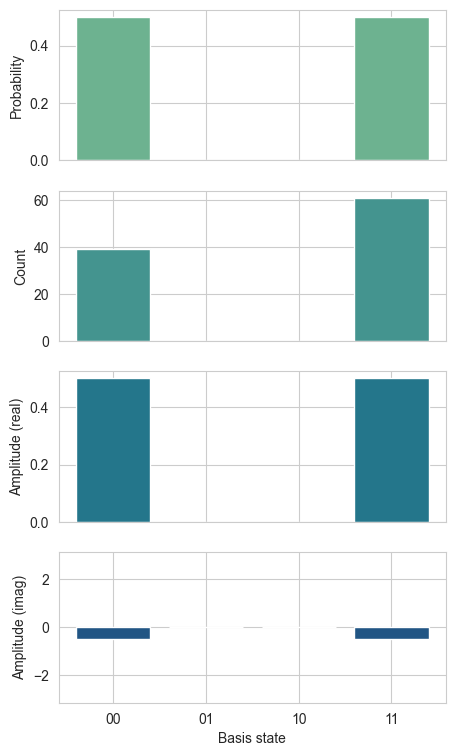

In [25]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=[5, 9])

state = np.array([basis.real + 1j * basis.imag for basis in results.state])
bases = [''.join(bits) for bits in itertools.product('01', repeat=n)]
counts = {basis: results.counts.get(basis, 0) for basis in bases}

ax = axs[0]
ax.bar(x=bases, height=np.abs(state)**2, color=colors[0])
ax.set(ylabel="Probability")


ax = axs[1]
ax.bar(x=bases, height=list(counts.values()), color=colors[1])
ax.set(ylabel="Count")


ax = axs[2]
ax.bar(x=bases, height=state.real, color=colors[2])
ax.set(ylabel="Amplitude (real)")

ax = axs[3]
ax.bar(x=bases, height=state.imag, color=colors[3])
ax.set(xlabel="Basis state", ylabel="Amplitude (imag)", ylim=[-np.pi, np.pi]);